In [ ]:
# see the actual derivation of these equations 
from IPython.display import YouTubeVideo
YouTubeVideo("WRr2e7mKCUY")

# Practical Implementation of Neural Networks

We define a new objective function as:

$$ J(\mathbf{W})=-[\mathbf{y}^{(i)}\ln[\mathbf{a}^{(L+1)}]^{(i)}+(1-\mathbf{y}^{(i)})\ln(1-[\mathbf{a}^{(L+1)}]^{(i)}) ]$$

Notice that this is highly similar to the log-likelihood we derived for logistic regression.

Such that the new update for the final layer becomes:

$$ \left[\frac{\partial J(\mathbf{W})}{\mathbf{z}^{(L)}}\right]^{(i)} = ([\mathbf{a}^{(L+1)}]^{(i)}- \mathbf{y}^{(i)}) $$

$$ \left[\frac{\partial J(\mathbf{W})}{\mathbf{z}^{(2)}}\right]^{(i)} = ([\mathbf{a}^{(3)}]^{(i)}- \mathbf{y}^{(i)})$$

And this is straight forward to convert to vectorized math for the sensitivity:

$$ \mathbf{V}^{(2)} = \mathbf{A}^{(3)}-\mathbf{Y} $$

Which can be derived as follows

$$
\begin{align}
J(\mathbf{W})&=-\left[\mathbf{y}^{(i)}\ln\phi([\mathbf{z}^{(L)}]^{(i)})+(1-\mathbf{y}^{(i)})\ln(1-[\phi(\mathbf{z}^{(L)}]^{(i)})) \right] \\
\frac{\partial J}{\partial \mathbf{z}^{(L)}} &=  -\left[\frac{\mathbf{y}^{(i)}}{\phi([\mathbf{z}^{(L)})]^{(i)}}\left( \frac{\partial}{\partial \mathbf{z}^{(L)}}\phi([\mathbf{z}^{(L)}]^{(i)}) \right)
+\frac{(1-\mathbf{y}^{(i)})}{(1-[\phi(\mathbf{z}^{(L)})]^{(i)})}\left( \frac{\partial}{\partial \mathbf{z}^{(L)}}(1-[\phi(\mathbf{z}^{(L)}]^{(i)}))\right) \right] \\
 &=  -\left[\frac{\mathbf{y}^{(i)}}{\phi([\mathbf{z}^{(L)}]^{(i)})} \phi([\mathbf{z}^{(L)}]^{(i)})\left(1-\phi([\mathbf{z}^{(L)}]^{(i)}) \right)
+\left(\frac{1-\mathbf{y}^{(i)}}{1-[\phi(\mathbf{z}^{(L)}]^{(i)})}\right)  \left(-\phi([\mathbf{z}^{(L)}]^{(i)})\left(1-\phi([\mathbf{z}^{(L)}]^{(i)}) \right)\right) \right] \\
 &=  -\left[\mathbf{y}^{(i)}\left(1-\phi([\mathbf{z}^{(L)}]^{(i)}) \right)
+\left(1-\mathbf{y}^{(i)}\right)  \left(-\phi([\mathbf{z}^{(L)}]^{(i)})\right) \right] \\
&=  -\left[\mathbf{y}^{(i)}-\mathbf{y}^{(i)}\phi([\mathbf{z}^{(L)}]^{(i)}) 
-\phi([\mathbf{z}^{(L)}]^{(i)})+\phi([\mathbf{z}^{(L)}]^{(i)})\mathbf{y}^{(i)}   \right] \\
&=  -\left[\mathbf{y}^{(i)}-\phi([\mathbf{z}^{(L)}]^{(i)})   \right] \\
&=  \phi([\mathbf{z}^{(L)}]^{(i)}) - \mathbf{y}^{(i)} \\
&=  [\mathbf{a}^{(L+1)}]^{(i)} - \mathbf{y}^{(i)} \\
\end{align}
$$

Another option is to choose the softmax, which is defined as:

$$  a_j^{(L+1)} = \frac{\exp(z_j^{(L)})}{\sum_i \exp(z_i^{(L)})}  $$

However, it has an identical update equation as the sigmoid final layer using cross entropy. We will stick with cross entropy in order to keep the consistency to previous feedforward code. However, please note that that sigmoid activation functions are more susceptible to gradient instability. 

In [1]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

##  Momentum, Mini-batch and Cooling
Like in the previous notebook, we will add in momentum, cooling and min-batching to the implementation to get a better optimizer. 

As a bonus, let's add support for keeping track of the validation in the training loop. That is, we will add in a calculation to test the validation loss and accuracy at the end of each epoch.

In [2]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * gradW1, eta * gradW2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self
    

## [End review]
___

## Start of new material

In [3]:
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
        
    

In [4]:

# more diverse fashion MNIST data
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
# from sklearn.preprocessing import RobustScaler
 
def load_mnist(path, kind='fashion_train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

X_train, y_train = load_mnist('data/', kind='fashion_train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('data/', kind='fashion_t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_train = X_train/255.0 - 0.5
X_test = X_test/255.0 - 0.5


Rows: 60000, columns: 784
Rows: 10000, columns: 784


In [5]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':20, 'eta':0.01, # poor starting learning rate!!
         'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
         'minibatches':50,
         'shuffle':True,'random_state':1}

nn_quad = TLPMiniBatch(**vals)
nn_cross = TLPMiniBatchCrossEntropy(**vals)

%time nn_cross.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_quad.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print("Done")

Epoch: 1/200

CPU times: user 30.4 s, sys: 2.58 s, total: 33 s
Wall time: 8.47 s


Epoch: 20/20

CPU times: user 27.1 s, sys: 2.04 s, total: 29.2 s
Wall time: 7.32 s
Done


In [6]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

Cross Entropy Loss :
Resubstitution acc: 0.83525
Validation acc: 0.8179
MSE Loss :
Resubstitution acc: 0.11028333333333333
Validation acc: 0.1109


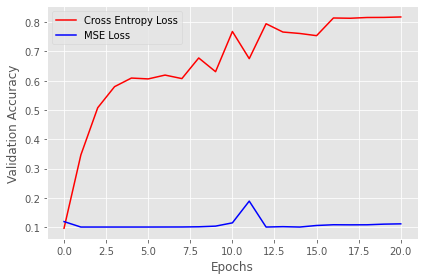

In [7]:
print_result(nn_cross,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")
print_result(nn_quad,X_train,y_train,X_test,y_test,title="MSE Loss",color="blue")

plt.show()

## [Back to Slides]

In [8]:
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2

Epoch: 1/200

CPU times: user 50.8 s, sys: 4.82 s, total: 55.6 s
Wall time: 14.2 s


Epoch: 20/20

CPU times: user 51.7 s, sys: 5.01 s, total: 56.8 s
Wall time: 14.4 s
Traditional :
Resubstitution acc: 0.8404666666666667
Validation acc: 0.8269
Glorot Initial :
Resubstitution acc: 0.8677333333333334
Validation acc: 0.848


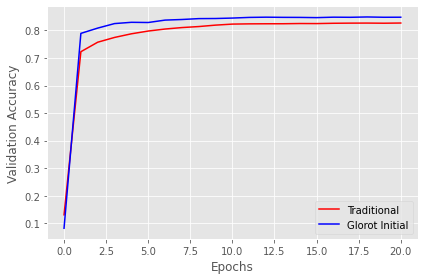

In [11]:
vals['epochs'] = 20
vals['eta'] = 0.001

nn_tradit = TLPMiniBatchCrossEntropy(**vals)
nn_better = TLPBetterInitial(**vals)

%time nn_tradit.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

print_result(nn_tradit,X_train,y_train,X_test,y_test,title="Traditional",color="red")
print_result(nn_better,X_train,y_train,X_test,y_test,title="Glorot Initial",color="blue")
plt.show()

Epoch: 75/75

CPU times: user 3min 3s, sys: 17 s, total: 3min 20s
Wall time: 51 s
Long Run :
Resubstitution acc: 0.8976333333333333
Validation acc: 0.8641


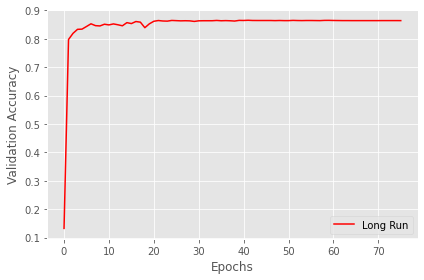

In [12]:
# just for fun, let's look at the output of what happens when we let our system loose
# these values have been hand tuned
vals = {'n_hidden':50, 
         'C':1e-2, 'epochs':75, 'eta':0.005, 
         'alpha':0.1, 'decrease_const':0.1,
         'decrease_iter':20,
         'minibatches':len(X_train)/256,
         'shuffle':True,'random_state':1}

nn_long_sigmoid = TLPBetterInitial(**vals)

%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))
print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")

______
**Self Test**: Resubstitution accuracy is more important than validation accuracy when training.
- A. True
- B. False
- C. It depends



## [Back To Slides]
_____

# Rectified Linear Units
Now lets look at another type of activation function. The rectified linear unit (ReLu) is an interesting choice to use because of its simplicity. Moreover, we will learn that its backpropagated derivative has some characteristics that are advantageous. 

We define the ReLu neuron as:

$$
    \phi(\mathbf{z}^{(i)})=\left\{
                \begin{array}{ll}
                \mathbf{z}^{(i)}  \text{,  if }\mathbf{z}^{(i)}>0 \\
                \mathbf{0} \text{,      else } \\
                \end{array}
              \right.
$$

Which has a very simple derivative:
$$
    \frac{\partial\phi(\mathbf{z}^{(i)})}{\partial\mathbf{z}^{(i)}}=\left\{
                \begin{array}{ll}
                \mathbf{1} \text{,  if }\mathbf{z}^{(i)}>0 \\
                \mathbf{0} \text{,      else } \\
                \end{array}
              \right.
$$

In [13]:
class TLPReLU(TLPBetterInitial):
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        # suggested relu/sigmoid bounds
        #Xavier Glorot, Yoshua Bengio ; 
        #  Understanding the difficulty of training deep feedforward neural networks
        #  Conference on Artificial Intelligence and Statistics, PMLR 9:249-256, 2010.
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0, Z.copy())
        
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        """
        # A1->W1->ReLu->A2->W2->Sigmoid
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._relu(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2) # never use relu as last layer for classification (yuck!)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) 
        
        # V3[Z2<=0] = 0 # could can change to be relu back prop on this layer too!
        
        # old update: V1 = A2*(1-A2)*(W2.T @ V2)
        # the derivative of sigmoid was A2(1-A2), but now that is relu
        # so we change it to:
        
        V1 = (W2.T @ V2) 
        V1[Z1<=0] = 0
        # relu derivative only zeros out certain values! easy!
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += (W1 * self.l2_C)
        gradW2 += (W2 * self.l2_C)

        return gradW1, gradW2, gradb1, gradb2
    


In [14]:
vals['eta'] = 0.0001 # needs much smaller starting learning rate
nn_long_relu = TLPReLU(**vals) # same as previous parameter values
%time nn_long_relu.fit(X_train, y_train, print_progress=True, XY_test=(X_test,y_test))
print(vals)

Epoch: 75/75

CPU times: user 2min 55s, sys: 16.6 s, total: 3min 11s
Wall time: 48.9 s
{'n_hidden': 50, 'C': 0.01, 'epochs': 75, 'eta': 0.0001, 'alpha': 0.1, 'decrease_const': 0.1, 'decrease_iter': 20, 'minibatches': 234.375, 'shuffle': True, 'random_state': 1}


ReLU :
Resubstitution acc: 0.877
Validation acc: 0.8551
Sigmoid :
Resubstitution acc: 0.8976333333333333
Validation acc: 0.8641


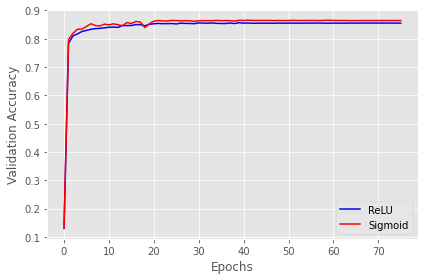

In [15]:
print_result(nn_long_relu, X_train, y_train, X_test, y_test, title="ReLU",color="blue")
print_result(nn_long_sigmoid, X_train, y_train, X_test, y_test, title="Sigmoid",color="red")

# Sklearn Implementation
Let's see if our method stacks up to the implementations from `scikit-learn`.

In [16]:
from sklearn import __version__ as sklearn_version
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

print(sklearn_version)
# these values have been hand tuned
# sigmoid with SGD, batching, nesterov's momentum, 
# L2, adaptive learning rate
clf = MLPClassifier(hidden_layer_sizes=(50,), 
                    activation='logistic', # compare to sigmoid
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size=128, # min of 128, num_samples
                    learning_rate='adaptive', # decrease rate if loss goes up
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD with inverse scaling
                    max_iter=100, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(yhat,y_test))

1.0.2
CPU times: user 3min 20s, sys: 18.8 s, total: 3min 39s
Wall time: 55.2 s
Validation Acc: 0.8725


/Users/ericlarson/opt/anaconda3/envs/mlenv2022/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [17]:
# but with this implementation we can also easily change Neurons
# ReLU with SGD, batching, simple momentum, 
# L2, adaptive learning rate
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='relu', # type of non-linearity, every layer except output layer
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size= 128, # min of 128, num_samples
                    learning_rate='adaptive', # adapt learning? 
                    learning_rate_init=0.1, # only SGD
                    power_t=0.0,    # only SGD with inverse scaling of learning rate
                    max_iter=100, # stopping criteria
                    shuffle=True, 
                    random_state=1, 
                    tol=0, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=False, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.0, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(yhat,y_test))

CPU times: user 3min 12s, sys: 18 s, total: 3min 30s
Wall time: 53.1 s
Validation Acc: 0.8678


/Users/ericlarson/opt/anaconda3/envs/mlenv2022/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [18]:
# but what if we also use AdaM optimization?
# ReLU with AdaM, batching, simple momentum, 
# L2, adaptive learning rate
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='relu', # type of non-linearity, every layer except output layer
                    solver='adam', 
                    alpha=1e-4, # L2 penalty
                    batch_size= 128, # min of 200, num_samples
                    learning_rate='adaptive', # adapt learning? 
                    learning_rate_init=0.01, # only SGD
                    power_t=1,    # only SGD with inverse scaling of learning rate
                    max_iter=100, # stopping criteria
                    shuffle=True, 
                    random_state=1, 
                    tol=0, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=False, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.0, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(yhat,y_test))

/Users/ericlarson/opt/anaconda3/envs/mlenv2022/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


CPU times: user 17min 11s, sys: 47.8 s, total: 17min 58s
Wall time: 4min 31s
Validation Acc: 0.858


## In this notebook, you learned:
- Simple optimization methods and tricks for Neural Networks
- Cross Entropy Loss
- Glorot and He Initialization
- Rectified Linear Activation Functions